<a href="https://colab.research.google.com/github/adantra/nangs/blob/master/Difussion1D_1_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nangs

In [28]:
pip install --upgrade git+https://github.com/adantra/nangs.git

  Cloning https://github.com/adantra/nangs.git to /tmp/pip-req-build-2qdqzz11
  Running command git clone -q https://github.com/adantra/nangs.git /tmp/pip-req-build-2qdqzz11
  Created wheel for nangs: filename=nangs-0.1.2-cp37-none-any.whl size=13860 sha256=a09b04df717d9ca8fa7da6f4ff47dbd9ab21bbee1d99b05e3882c1e767d09903
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbld0hdp/wheels/2c/7f/7f/677931a26064faa3c2f5f1f88c96cae03fadc9cffb901d8b1e
Successfully built nangs
  Found existing installation: nangs 0.1.2
    Uninstalling nangs-0.1.2:
      Successfully uninstalled nangs-0.1.2


In [29]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.9.0+cu102')

In [31]:
device


'cuda'

In [145]:
alpha=10
class Difussion2d(PDE):
    def computePDELoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        # second order derivatives        
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0] 
        #dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        return {'pde':dpdt - dp2dx2}

In [146]:
class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx = grads[:, 0]
        return {'gradX': 100*dpdx}

In [147]:
class PBC0(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        pbc = 0
        p = outputs[:, 0]
        return {'PWF': 100*(p-pbc)}

In [148]:
pde = Difussion2d(inputs=('x', 't'), outputs='p')

In [149]:
def append(arr, values, axis=None):
    arr = np.asanyarray(arr)
    if axis is None:
        if arr.ndim != 1:
            arr = arr.ravel()
        values = np.ravel(values)
        axis = arr.ndim-1
    return np.concatenate((arr, values), axis=axis)

In [150]:
# mesh 

x = np.linspace(0,1,100)

t = np.linspace(0,1,100)
#t = append(t,np.linspace(0.2,1,10))
#t=np.array([0])
#tt=np.logspace(-2,0,20)
#t = append(t,tt)
#mesh = Mesh({'x': x, 't':t}, device=device)
#pde.set_mesh(mesh)

In [151]:
x = np.append(np.linspace(0,.01,10),x)

t = np.append(np.linspace(0,.01,10),t)
#t = append(t,np.linspace(0.2,1,10))
#t=np.array([0])
#tt=np.logspace(-2,0,20)
#t = append(t,tt)
mesh2 = Mesh({'x': x, 't':t}, device=device)
pde.set_mesh(mesh2)

In [152]:
from nangs import Dirichlet

In [153]:
t0 = np.array([0])

In [154]:
_x = np.meshgrid(x)
#p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

In [155]:

_x[0].shape

(110,)

In [161]:
p0=np.zeros((len(x)))
p0[:]=1
p0[0]=0
#p0[47:53,47:53]=1

In [162]:
p0.shape

(110,)

In [163]:
initial_condition = Dirichlet({'x': x,'t':t0}, {'p': p0.reshape(-1)}, device=device, name="initial")

In [164]:
p0.shape

(110,)

In [165]:
pde.add_boco(initial_condition)
#p0=np.ones(len(y))
#p1=np.zeros(len(y))

In [166]:
pwf = PBC0({'x': np.array([0]),'t':t}, name='pwf', device=device)
#left = Dirichlet({'x': x, 'y': y}, {'p': p0.reshape(-1)}, device=device, name="left")

In [167]:

pde.add_boco(pwf)

In [168]:
#right = PBC0({'x': np.array([1]), 'y': y, 't':t}, name='right', device=device)
#right = Dirichlet({'x': x[-1], 'y': y}, {'p': p1.reshape(-1)}, device=device, name="right")
right =  NeumannX({'x': x[-1],'t':t}, name='right', device=device)

In [169]:
pde.add_boco(right)

In [170]:
#from nangs import MLP

BATCH_SIZE = 128
LR = 1e-2
EPOCHS = 2
NUM_LAYERS = 4
NUM_HIDDEN = 50

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [171]:
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (3): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (4): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [172]:

EPOCHS = 300
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [173]:
pde.compile(mlp, optimizer, scheduler)

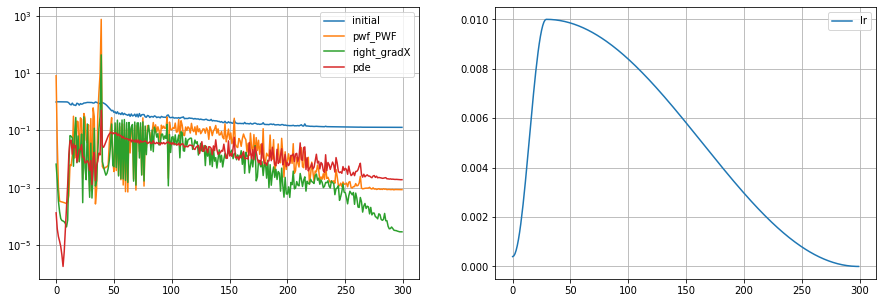

CPU times: user 10min 29s, sys: 13.8 s, total: 10min 43s
Wall time: 10min 52s


In [174]:

%time hist = pde.solve(EPOCHS, BATCH_SIZE)

In [121]:
hist['pde'][-1]

0.004050046222676572

In [122]:
t = 0.0
x = np.linspace(0,1,100)
#y = np.linspace(0,1,100)

_x, _t = np.meshgrid(x, t)
eval_mesh = Mesh({'x': x,  't':t}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()
#p5 = p.reshape((_y.shape[0],_x.shape[1]))

In [123]:
p,grad,loss=pde.eval_with_grad(eval_mesh)

In [192]:
ppp=[]
loss = []
x = np.linspace(0.0,1.,10)
qq=[]
for t in np.linspace(0.01,1,120):
  #_x,_t = np.meshgrid(x,t)
  eval_mesh = Mesh({'x': x,  't':t}, device=device)
  pp,g,l = pde.eval_with_grad(eval_mesh)
  qq.append(g)
  loss.append(l)
  #pp = pp.cpu().numpy()
  ppp.append(pp)

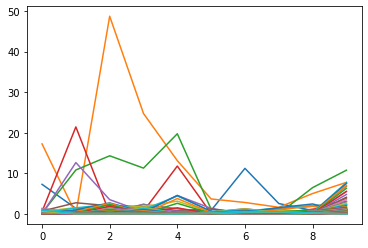

In [193]:
for l in loss:
  plt.plot(np.power(l,2)/hist['pde'][-1])

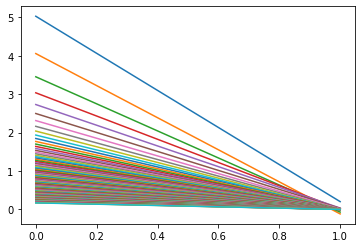

In [196]:
q0=[]
qL=[]
for q in qq:
  plt.plot(q.detach().cpu().numpy()[0])
  q0.append(q.detach().cpu().numpy()[0][0])
  qL.append(q.detach().cpu().numpy()[0][-1])

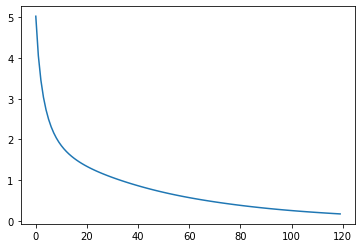

In [195]:
plt.plot(q0)

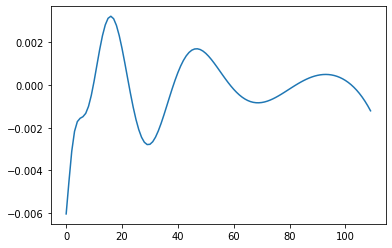

In [201]:
plt.plot(qL[10:])

In [88]:
from sympy import Sum, factorial, oo, IndexedBase, Function, sin,exp
from sympy.abc import n

In [89]:
def diff_sol(x,t,alpha=0.1):
    sol= Sum(4/((2*n + 1)*np.pi)*sin((2*n+1)*np.pi/2*x)*exp(-((2*n + 1)*np.pi/2)**2*t*alpha),(n,0,50))
    
    return sol #,sol_n

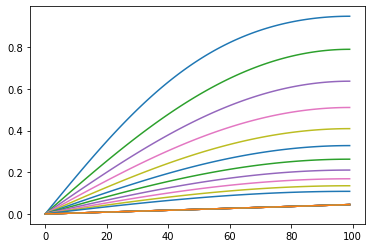

In [384]:
xxx=np.linspace(0,1,100)
for t in np.linspace(0.1,1,11):
    d=[]
    for xx in xxx:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d)
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(p)

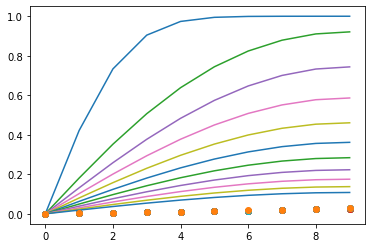

In [149]:
xxx=np.linspace(0,1,10)
x = np.linspace(0,1,10)
for t in np.linspace(0.02,1,11):
    d=[]
    for xx in xxx:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d)
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='o',linestyle='None')

In [356]:

out=pde.eval_with_grad(eval_mesh)

In [372]:
out_np=out[1].detach().cpu().numpy()

In [374]:
out_np.shape

(100, 2)

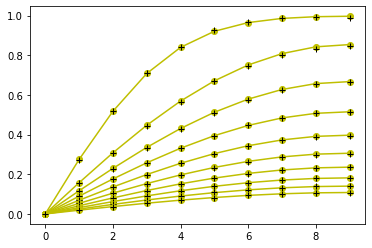

In [142]:
#xxx=np.linspace(0,1,10)
x = np.linspace(0,1,10)
for t in np.linspace(0.05,1,10):
    d=[]
    for xx in x:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d,marker='o',color='y')
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='+',linestyle='None',color='black')

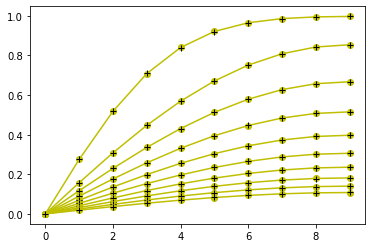

In [175]:
x = np.linspace(0,1,10)
for t in np.linspace(0.05,1,10):
    d=[]
    for xx in x:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d,marker='o',color='y')
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='+',linestyle='None',color='black')

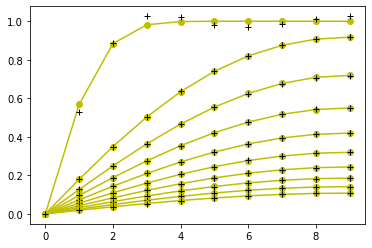

In [176]:
x = np.linspace(0,1,10)
for t in np.linspace(0.01,1,10):
    d=[]
    for xx in x:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d,marker='o',color='y')
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='+',linestyle='None',color='black')